In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
# The following is only for working with RDDs
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
train_owns_stars = pd.read_csv('data/new_subset_data/train_data.csv')
test_owns_stars = pd.read_csv('data/new_subset_data/test_data.csv')

sp_train_owns_stars = spark.createDataFrame(train_owns_stars)
sp_test_owns_stars = spark.createDataFrame(test_owns_stars)

In [11]:
model1 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=5,
    maxIter=15,
    alpha=10
    ) 

model2 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=10,
    maxIter=15,
    alpha=10
    )  

model3 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=15,
    maxIter=15,
    alpha=10
    )  

model4 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=20,
    maxIter=15,
    alpha=10
    )  

model5 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15,
    alpha=10
    ) 

model6 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=30,
    maxIter=15,
    alpha=10
    ) 

model7 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=35,
    maxIter=15,
    alpha=10
    ) 


# Fit models
recommender1 = model1.fit(sp_train_owns_stars)
recommender2 = model2.fit(sp_train_owns_stars)
recommender3 = model3.fit(sp_train_owns_stars)
recommender4 = model4.fit(sp_train_owns_stars)
recommender5 = model5.fit(sp_train_owns_stars)
recommender6 = model6.fit(sp_train_owns_stars)
recommender7 = model7.fit(sp_train_owns_stars)

models = [recommender1, recommender2, recommender3, recommender4, recommender5, recommender6, recommender7]

In [51]:
def evaluate_models(trained_models, testdf):
    ranks = []
    rmses = []
    for model in trained_models:
        predictions = model.transform(testdf)
        pred_df = predictions.toPandas()
        rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))
        
        predictions = rawPredictions\
        .withColumn("interest_rank", rawPredictions.interest_rank.cast("double"))\
        .withColumn("prediction", rawPredictions.prediction.cast("double"))
       
        evaluator =\
        RegressionEvaluator(metricName="rmse", labelCol="interest_rank", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        
        ranks.append(model.rank)
        rmses.append(rmse)
    return rmses, ranks
    

In [52]:
rmse, rank = evaluate_models(models, sp_test_owns_stars)

In [18]:
rmse

[0.3740496420218617,
 0.32314478192966867,
 0.3151265172986602,
 0.30467200256505556,
 0.29878662038768905,
 0.2986263091786887,
 0.2983536223108384]

In [19]:
rank

[5, 10, 15, 20, 25, 30, 35]

# Use 25-30 latent features (rank)

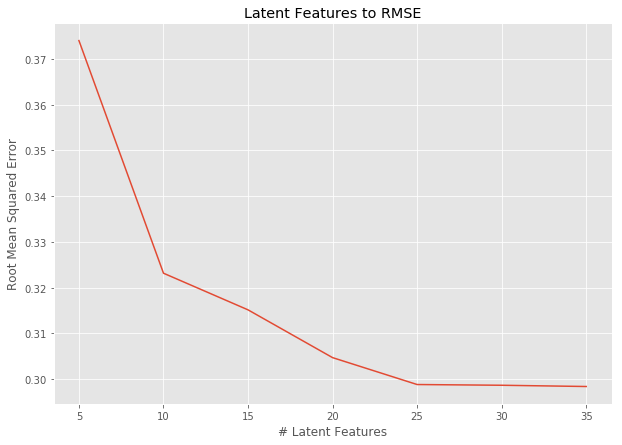

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(rank, rmse)
ax.set_title("Latent Features to RMSE")
ax.set_ylabel("Root Mean Squared Error")
ax.set_xlabel("# Latent Features");

# Other parameters: alpha

In [53]:
model8 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15,
    alpha=1.0
    ) 

model9 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15,
    alpha=5.0
    ) 

model10 = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15,
    alpha=20.0
    ) 

recommender8 = model8.fit(sp_train_owns_stars)
recommender9 = model9.fit(sp_train_owns_stars) 
recommender10 = model10.fit(sp_train_owns_stars) 

models_alpha = [recommender8, recommender9, recommender10]

In [54]:
rmse, alpha = evaluate_models(models_alpha, sp_test_owns_stars)

In [55]:
alpha = [1, 5, 20]

## Using different alphas different change RMSE

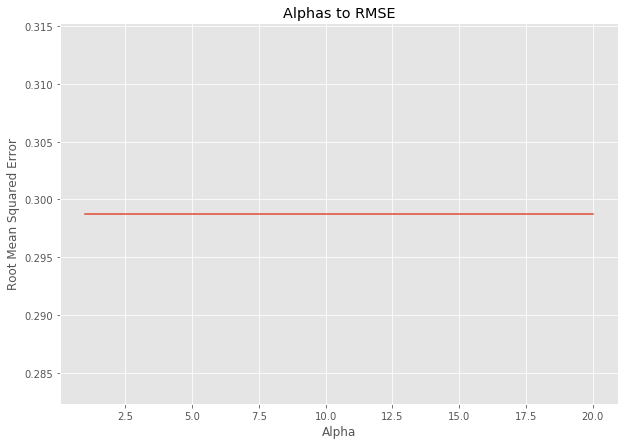

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(alpha, rmse)
ax.set_title("Alphas to RMSE")
ax.set_ylabel("Root Mean Squared Error")
ax.set_xlabel("Alpha");